In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import RESULTS_DIR, SUBJECTS
from data import MODALITY_AGNOSTIC
from eval import ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST
from notebook_utils import create_result_graph, load_results_data, ACC_MEAN, get_data_default_feats, FEATS_MULTIMODAL, DEFAULT_FEAT_OPTIONS
from scipy.stats import ttest_ind

sns.set_style("ticks", {'axes.grid': True})



In [4]:
MODELS = [
    "random-imagebind", "vit-b-16", "vit-l-16", "vit-h-14", "resnet-18", "resnet-50", "resnet-152", "dino-base", "dino-large", "dino-giant",
    "bert-base-uncased", "bert-large-uncased", "llama2-7b", "llama2-13b", "mistral-7b", "mixtral-8x7b", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl",
    "visualbert", "bridgetower", "vilt", "siglip", "paligemma2", "clip", "flava", "blip2", "imagebind"
]

# for model in MODELS:
#     print(model, end=" ")


In [5]:
all_data = load_results_data(MODELS, recompute_acc_scores=False)

all_data = all_data[all_data["mask"] == "whole_brain"]
all_data_vol = all_data[all_data.surface == False].copy()

all_data = all_data[all_data.surface == True].copy()

multimodal_models = all_data[all_data.features.isin(FEATS_MULTIMODAL)].model.unique().tolist()
vision_models = [m for m in all_data[all_data.features == "vision"].model.unique() if len(all_data[all_data.model == m].features.unique()) == 1]


100%|██████████| 714/714 [00:00<00:00, 1788.00it/s]


In [6]:
data_default_feats = get_data_default_feats(all_data)

In [8]:
model_order = ['random-imagebind']
model_feat_order = ['random-imagebind_avg']
for features in DEFAULT_FEAT_OPTIONS:
    print('\nmodel feat type: ', features)
    dp = data_default_feats.copy()
    dp = dp[dp.features == features]
    dp = dp[dp.training_mode == MODALITY_AGNOSTIC]
    
    dp = dp[dp.metric == ACC_MEAN]
    for model in dp.model.unique():
        if len(dp[dp.model == model]) != len(SUBJECTS):
            print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
    scores = dp.groupby("model_feat").value.mean().sort_values()
    if len(scores) > 0:
        print(scores)
        model_order.extend([mf.split('_')[0] for mf in scores.index.values])
        model_feat_order.extend(scores.index.values)
    
model_order
# model_feat_order


model feat type:  vision
model_feat
resnet-152_vision    0.771239
vit-b-16_vision      0.772136
vit-l-16_vision      0.796411
resnet-18_vision     0.802277
vit-h-14_vision      0.803761
resnet-50_vision     0.807350
dino-large_vision    0.816253
dino-base_vision     0.819341
dino-giant_vision    0.820204
Name: value, dtype: float64

model feat type:  lang
model_feat
bert-large-uncased_lang    0.799741
bert-base-uncased_lang     0.822533
llama2-7b_lang             0.829693
mixtral-8x7b_lang          0.830814
mistral-7b_lang            0.833092
gpt2-small_lang            0.843202
llama2-13b_lang            0.845428
gpt2-medium_lang           0.848033
gpt2-xl_lang               0.851639
gpt2-large_lang            0.853071
Name: value, dtype: float64

model feat type:  fused_mean
model_feat
visualbert_fused_mean    0.742892
vilt_fused_mean          0.839476
Name: value, dtype: float64

model feat type:  fused_cls
model_feat
bridgetower_fused_cls    0.815252
Name: value, dtype: float64

mo

['random-imagebind',
 'resnet-152',
 'vit-b-16',
 'vit-l-16',
 'resnet-18',
 'vit-h-14',
 'resnet-50',
 'dino-large',
 'dino-base',
 'dino-giant',
 'bert-large-uncased',
 'bert-base-uncased',
 'llama2-7b',
 'mixtral-8x7b',
 'mistral-7b',
 'gpt2-small',
 'llama2-13b',
 'gpt2-medium',
 'gpt2-xl',
 'gpt2-large',
 'visualbert',
 'vilt',
 'bridgetower',
 'random-imagebind',
 'clip',
 'flava',
 'paligemma2',
 'blip2',
 'siglip',
 'imagebind']

# Imagery decoding feat comparison

/home/mitja/code/multimodal_decoding/notebooks/notebook_utils.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels(


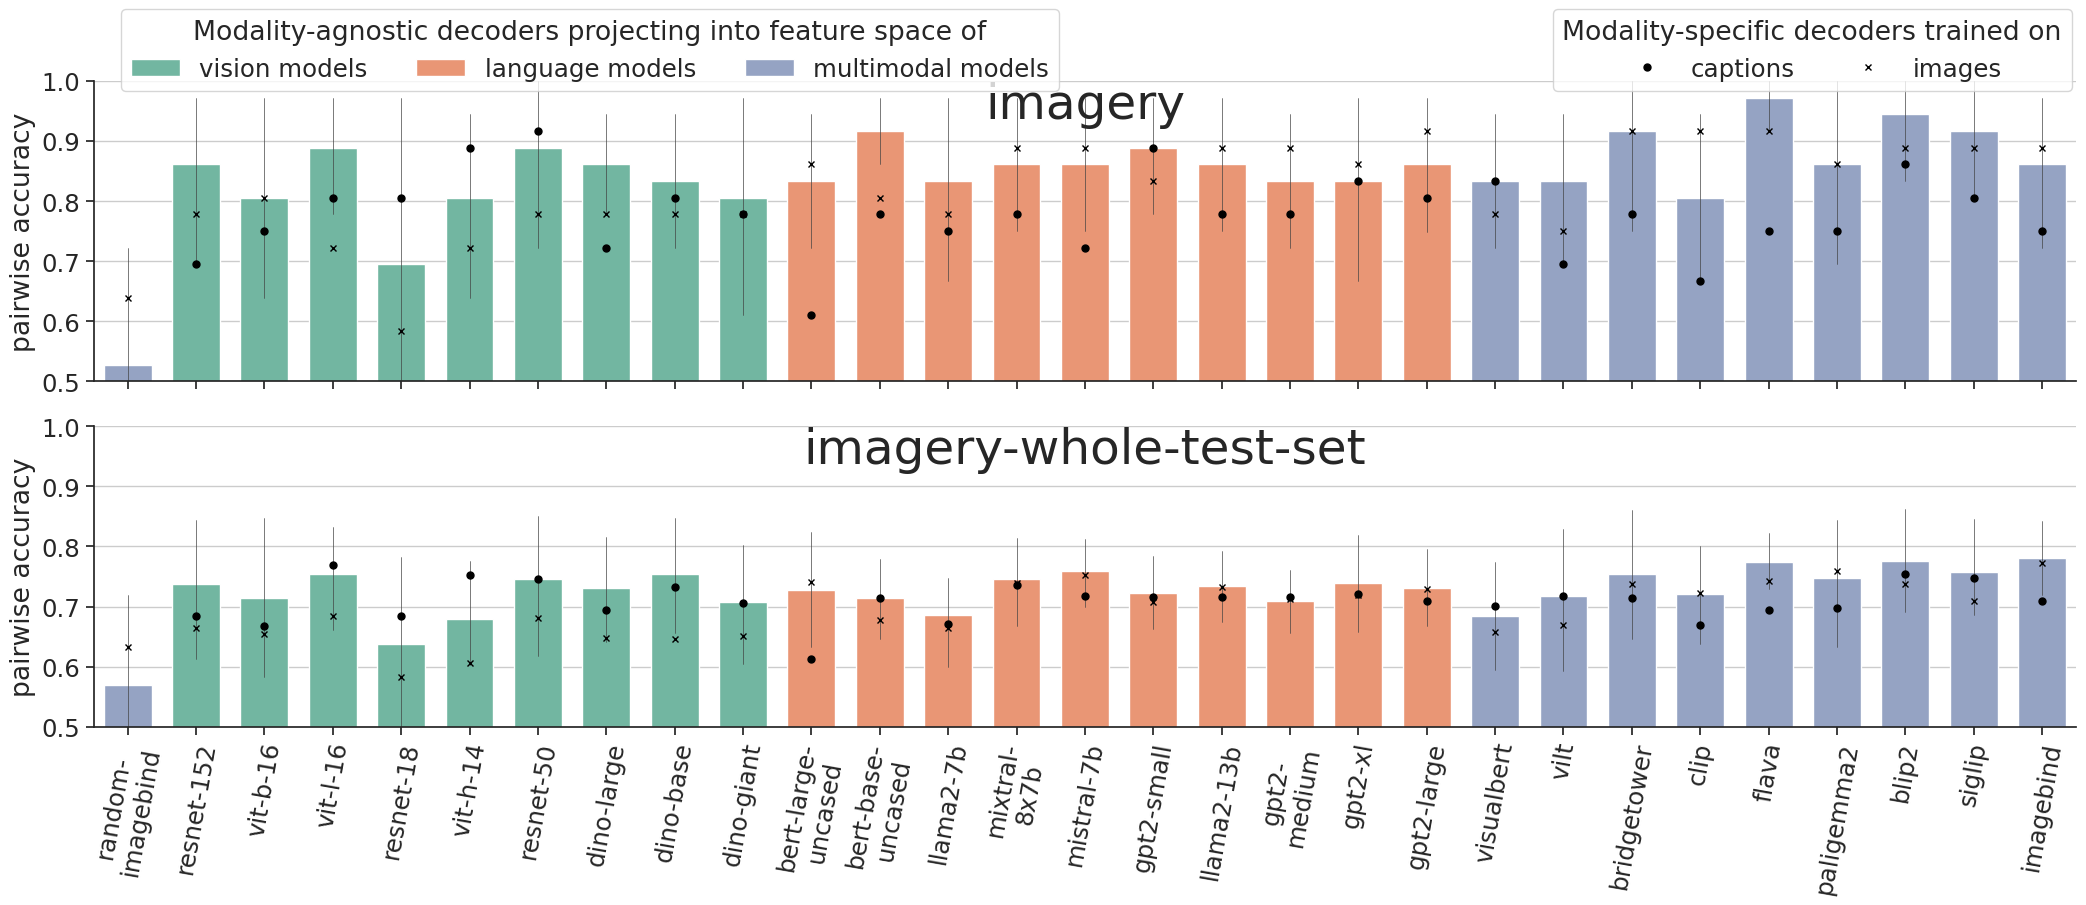

In [9]:
sns.set(font_scale=1.6)
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

metrics_order = [ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST]
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,1.03), legend_2_bbox=(0.99,1.03), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_imagery.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


# Imagery decoding with mask

In [10]:
MODEL = "imagebind"
# all_data_imagebind = load_results_data([MODEL], recompute_acc_scores=True, standardize_predictions=False)
all_data_imagebind = load_results_data([MODEL], recompute_acc_scores=False)

100%|██████████| 714/714 [00:00<00:00, 2484.02it/s]


acc whole brain: 0.78
mod_agnostic_and_cross_lh_threshold_0.01_cluster_0
6
acc masked: 0.76
TtestResult(statistic=0.4379085414896178, pvalue=0.6707600614337721, df=10.0)
mod_agnostic_and_cross_lh_threshold_100000.0_cluster_0
6
acc masked: 0.76
TtestResult(statistic=0.3367492730277778, pvalue=0.7432662979109574, df=10.0)
mod_agnostic_and_cross_lh_threshold_2000.0_cluster_0
6
acc masked: 0.76
TtestResult(statistic=0.4304287949816437, pvalue=0.6760127262638338, df=10.0)
mod_agnostic_and_cross_lh_threshold_200000.0_cluster_0
6
acc masked: 0.75
TtestResult(statistic=0.4906658198978929, pvalue=0.6342509701305554, df=10.0)
mod_agnostic_and_cross_lh_threshold_300000.0_cluster_0
6
acc masked: 0.74
TtestResult(statistic=0.61725521383291, pvalue=0.5508616758301107, df=10.0)
mod_agnostic_and_cross_lh_threshold_400000.0_cluster_0
6
acc masked: 0.70
TtestResult(statistic=0.9178849618024498, pvalue=0.3802847935778937, df=10.0)
mod_agnostic_and_cross_rh_threshold_0.01_cluster_0
6
acc masked: 0.77
Ttes

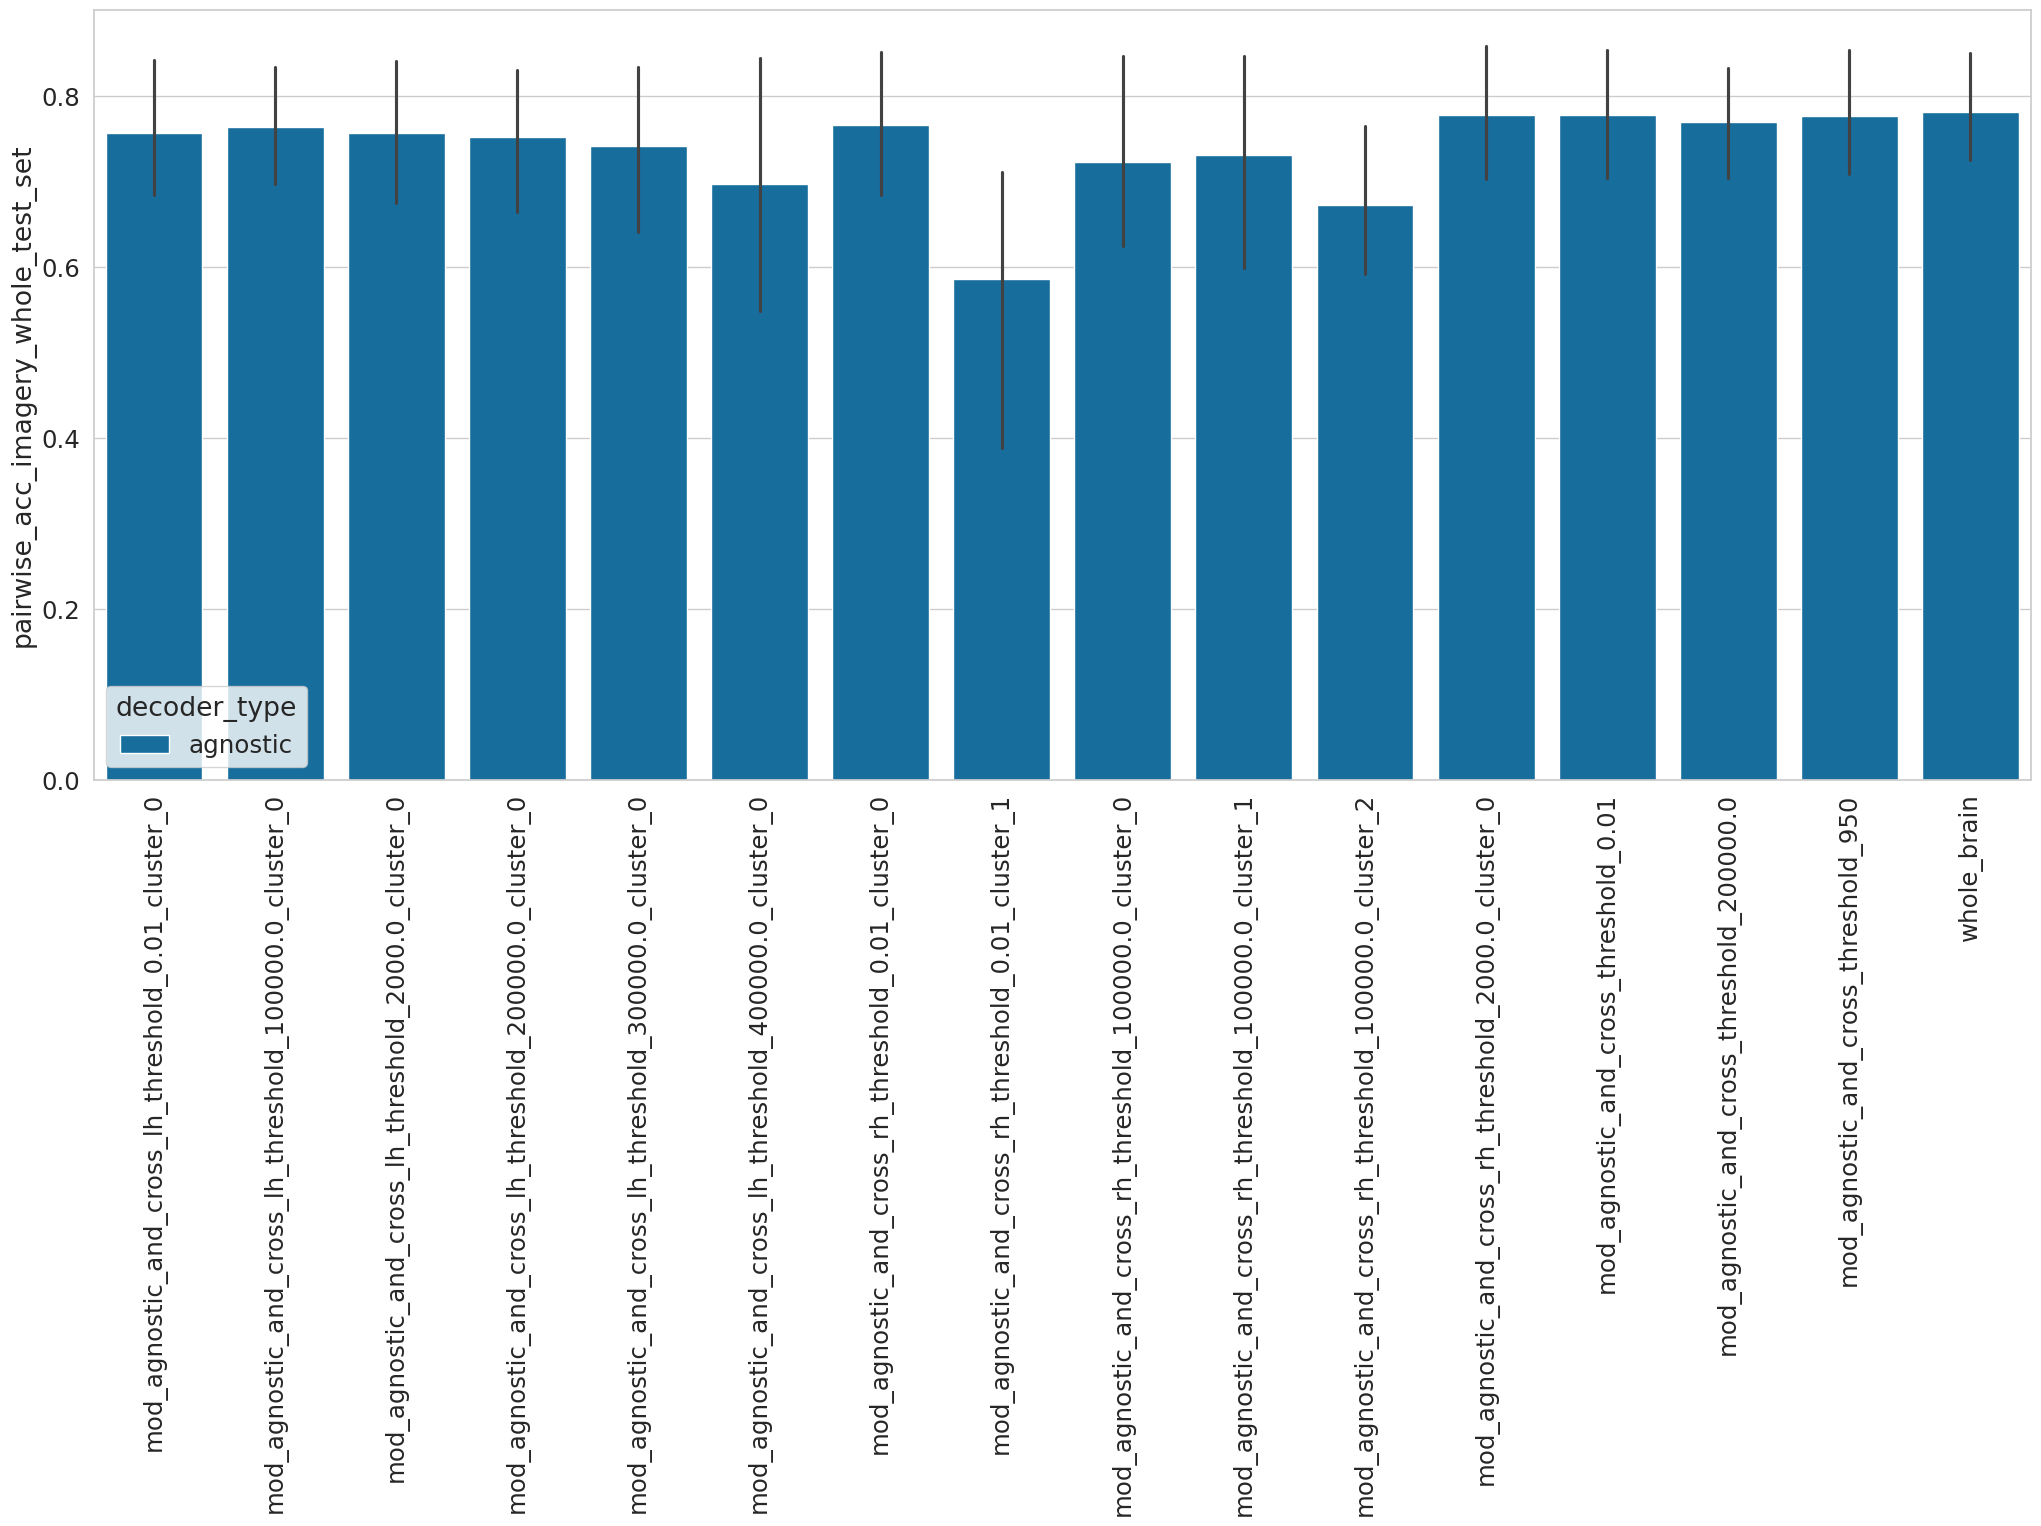

In [17]:
filtered = get_data_default_feats(all_data_imagebind)
# filtered = filtered[filtered.training_mode == "agnostic"]
filtered = filtered[filtered.surface == True]
# METRIC = ACC_IMAGERY
METRIC = ACC_IMAGERY_WHOLE_TEST
# METRIC = ACC_MEAN
# METRIC = ACC_IMAGES


filtered = filtered[filtered.metric == METRIC]

def shorten_mask_name(name):
    if name == "whole_brain":
        return name
    return os.path.basename(name).replace('mask_', '')

    
filtered["mask"] = filtered["mask"].apply(shorten_mask_name)
# print(filtered["mask"].unique())

# MASK_NAME = 'cross_encoding'
# MASK_NAME = 'cross_decoding_lh_threshold_400000.0_cluster_0'
# MASK_NAME = 'cross_decoding_rh_threshold_10000.0_cluster_0'
# MASK_NAME = 'mask_cross_decoding'
# MASK_NAME = 'diff_mod_agno_mod_specific'


# filtered = filtered[filtered["mask"].isin(['whole_brain', MASK_NAME])]
# filtered = filtered[~filtered["mask"].isin(['cross_encoding'])]


# filtered['mask'] = filtered['mask'].replace({MASK_NAME: True, 'whole_brain': False}).astype(bool)
# filtered['mask'] = filtered['mask'].replace({MASK_NAME: 'mod_agnostic_mask'})

filtered['decoder_type'] = filtered['training_mode']
ORDER = None# ['whole_brain', MASK_NAME]
HUE_ORDER = ['agnostic']#['captions', 'images', 'agnostic']

plt.figure(figsize=(25, 10))
# plt.title(METRIC)
sns.barplot(data=filtered, x="mask", y="value", hue="decoder_type", order=ORDER, hue_order=HUE_ORDER, palette=sns.color_palette("colorblind", len(HUE_ORDER)))
plt.xlabel('')
plt.ylabel(METRIC)
plt.xticks(rotation=90)
# _ = plt.xticks(rotation=90)
plt.savefig(os.path.join(RESULTS_DIR, f"masked_decoding_{METRIC}.png"), dpi=300, bbox_inches='tight', pad_inches=0)

pd.set_option('display.max_rows', 500)

grouped = filtered.groupby(["mask", 'decoder_type']).agg(count=('value', 'size'), num_voxels=('num_voxels', 'mean'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index()
grouped['num_voxels'] = grouped['num_voxels'].astype(int)
# display(grouped)

accs_agnostic = filtered[filtered.decoder_type=='agnostic']
accs_whole_brain = accs_agnostic[accs_agnostic['mask']=='whole_brain']

assert len(accs_whole_brain) == len(SUBJECTS)
print(f'acc whole brain: {accs_whole_brain.value.mean():.2f}')

for mask in accs_agnostic['mask'].unique():
    if mask != 'whole_brain':
        print(mask)
        accs_masked = accs_agnostic[accs_agnostic['mask']==mask]

        print(len(accs_masked))
        # assert len(accs_masked) == len(SUBJECTS) #
        
        # import statsmodels.formula.api as smf
        # formula = 'value ~ mask * C(decoder_type)'
        # model = smf.glm(formula=formula, data=filtered)#, family=family)
        # result = model.fit()
        # print(result.summary())
        
        print(f'acc masked: {accs_masked.value.mean():.2f}')
        print(ttest_ind(accs_whole_brain.value.values, accs_masked.value.values))
        
        # display(filtered.groupby(["mask"]).agg(count=('value', 'size'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index())
        # display(filtered.groupby(["mask", 'training_mode', 'subject']).agg(count=('value', 'size'), num_voxels=('num_voxels', 'mean'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index())
        # display(filtered.groupby(["mask", 'subject']).agg(count=('value', 'size'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index())
    



['mod_agnostic_and_cross_lh_threshold_0.01_cluster_0'
 'mod_agnostic_and_cross_lh_threshold_100000.0_cluster_0'
 'mod_agnostic_and_cross_lh_threshold_2000.0_cluster_0'
 'mod_agnostic_and_cross_lh_threshold_200000.0_cluster_0'
 'mod_agnostic_and_cross_lh_threshold_300000.0_cluster_0'
 'mod_agnostic_and_cross_lh_threshold_400000.0_cluster_0'
 'mod_agnostic_and_cross_rh_threshold_0.01_cluster_0'
 'mod_agnostic_and_cross_rh_threshold_0.01_cluster_1'
 'mod_agnostic_and_cross_rh_threshold_100000.0_cluster_0'
 'mod_agnostic_and_cross_rh_threshold_100000.0_cluster_1'
 'mod_agnostic_and_cross_rh_threshold_100000.0_cluster_2'
 'mod_agnostic_and_cross_rh_threshold_2000.0_cluster_0'
 'mod_agnostic_and_cross_threshold_0.01'
 'mod_agnostic_and_cross_threshold_200000.0'
 'mod_agnostic_and_cross_threshold_950' 'whole_brain']
acc whole brain: 0.78
lh_threshold_100000.0_cluster_0
6
acc masked: 0.76
TtestResult(statistic=0.3367492730277778, pvalue=0.7432662979109574, df=10.0)
lh_threshold_2000.0_cluster_

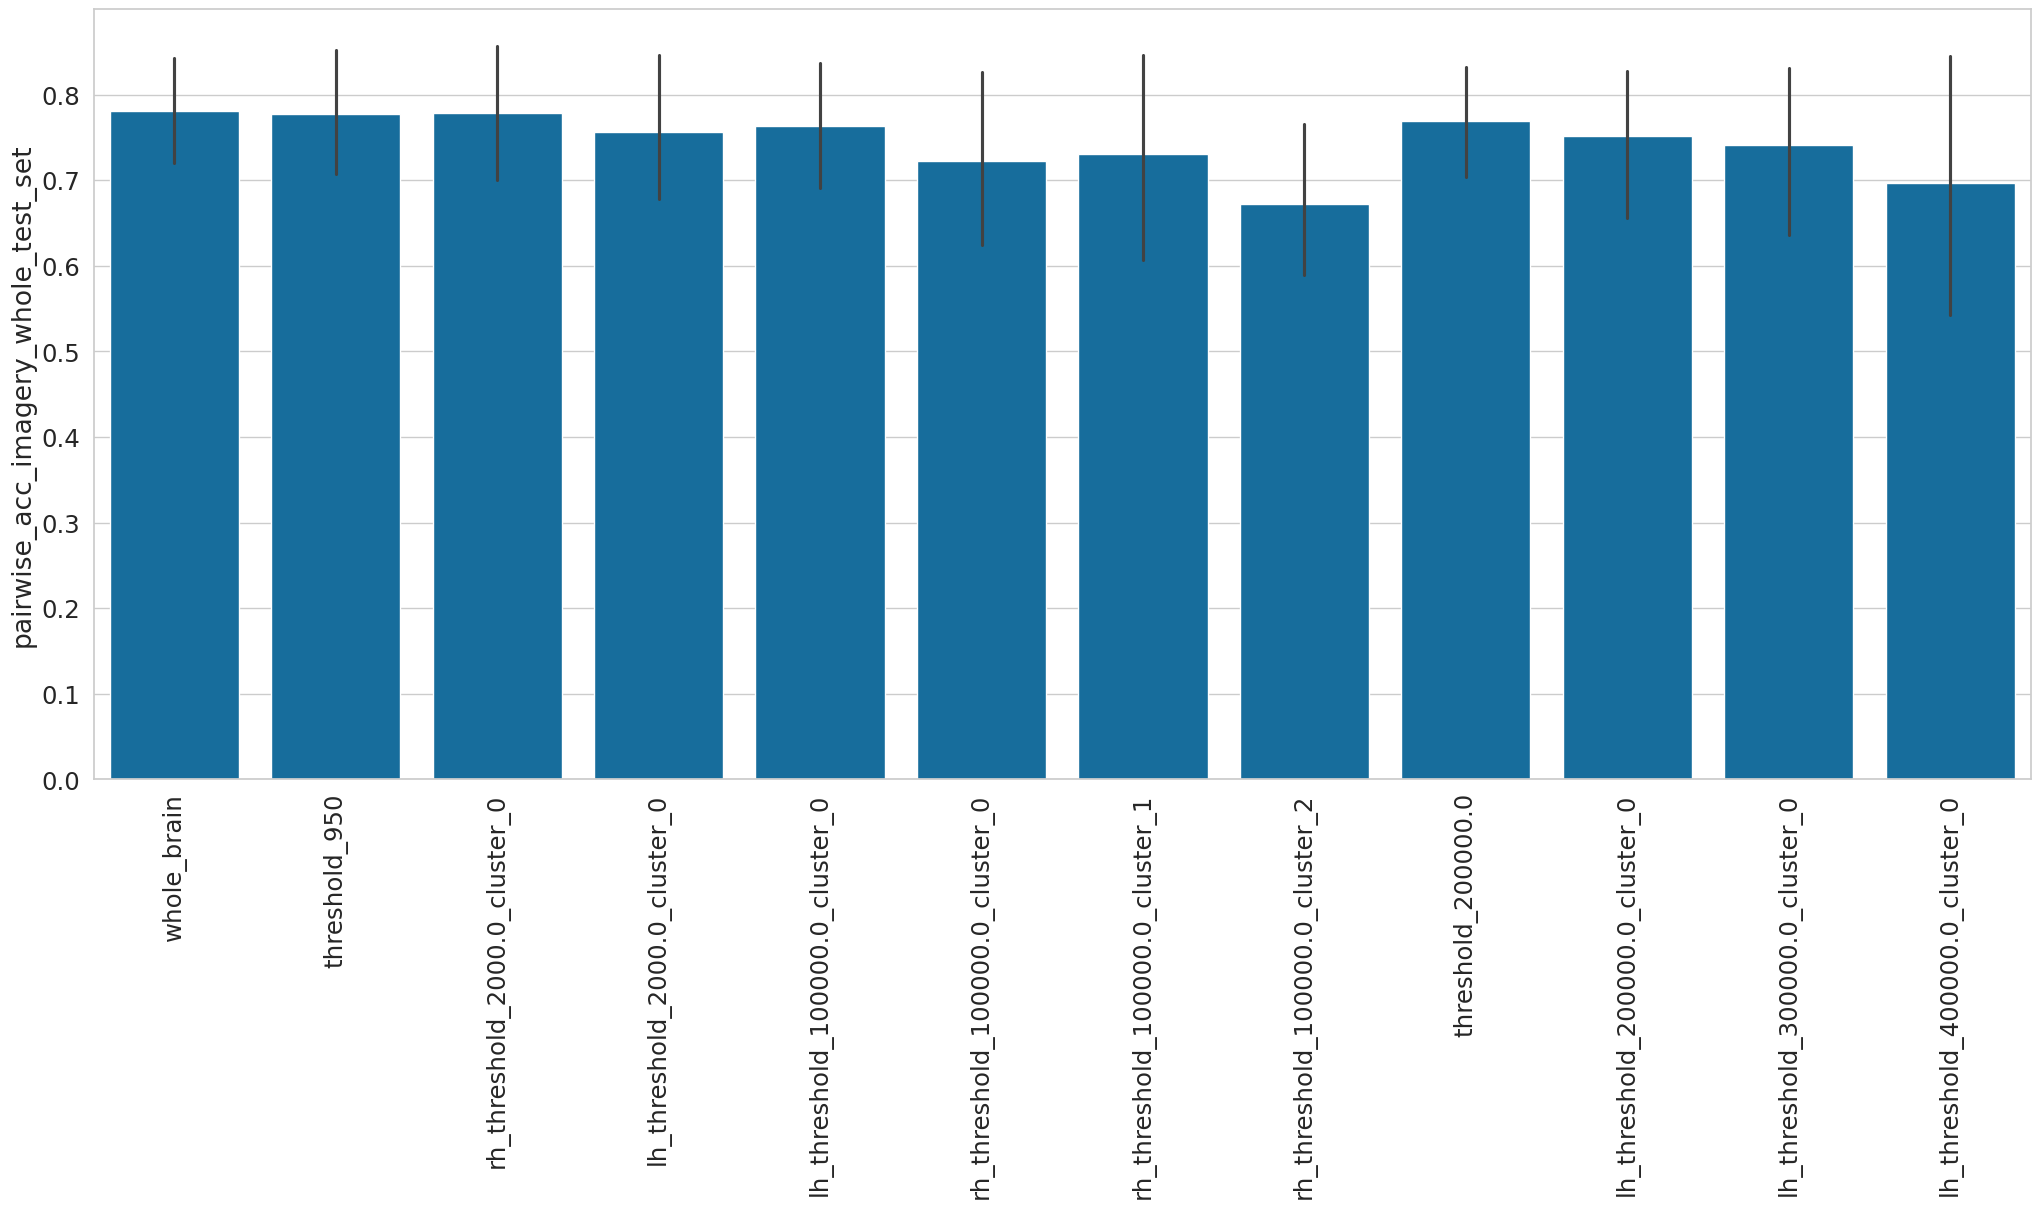

In [16]:
filtered = get_data_default_feats(all_data_imagebind)
# filtered = filtered[filtered.training_mode == "agnostic"]
filtered = filtered[filtered.surface == True]
# METRIC = ACC_IMAGERY
METRIC = ACC_IMAGERY_WHOLE_TEST
# METRIC = ACC_MEAN
# METRIC = ACC_IMAGES


filtered = filtered[filtered.metric == METRIC]
print(filtered['mask'].unique())
def shorten_mask_name(name):
    if name == "whole_brain":
        return name
    return os.path.basename(name).replace('mask_', '').replace('mod_agnostic_and_cross_', '')

    
filtered["mask"] = filtered["mask"].apply(shorten_mask_name)
# print(filtered["mask"].unique())

# MASK_NAME = 'cross_encoding'
# MASK_NAME = 'cross_decoding_lh_threshold_400000.0_cluster_0'
# MASK_NAME = 'cross_decoding_rh_threshold_10000.0_cluster_0'
# MASK_NAME = 'mask_cross_decoding'
# MASK_NAME = 'diff_mod_agno_mod_specific'


# filtered = filtered[filtered["mask"].isin(['whole_brain', MASK_NAME])]
filtered = filtered[~filtered["mask"].str.contains('0.01')]
# filtered = filtered[~filtered["mask"].str.contains('950')]


# filtered['mask'] = filtered['mask'].replace({MASK_NAME: True, 'whole_brain': False}).astype(bool)
# filtered['mask'] = filtered['mask'].replace({MASK_NAME: 'mod_agnostic_mask'})
filtered['decoder_type'] = filtered['training_mode']
# ORDER = None# ['whole_brain', MASK_NAME]
# print(filtered['mask'].unique())
ORDER = [
    'whole_brain',
 'threshold_950',
 'rh_threshold_2000.0_cluster_0',
 'lh_threshold_2000.0_cluster_0',
 'lh_threshold_100000.0_cluster_0',
 'rh_threshold_100000.0_cluster_0',
 'rh_threshold_100000.0_cluster_1',
 'rh_threshold_100000.0_cluster_2',
 'threshold_200000.0',
 'lh_threshold_200000.0_cluster_0',
 'lh_threshold_300000.0_cluster_0',
 'lh_threshold_400000.0_cluster_0',
 ]
HUE_ORDER = ['agnostic']#['captions', 'images', 'agnostic']

plt.figure(figsize=(25, 10))
# plt.title(METRIC)
sns.barplot(data=filtered, x="mask", y="value", hue="decoder_type", order=ORDER, hue_order=HUE_ORDER, palette=sns.color_palette("colorblind", len(HUE_ORDER)), legend=False)
plt.xlabel('')
plt.ylabel(METRIC)
plt.xticks(rotation=90)
# _ = plt.xticks(rotation=90)
plt.savefig(os.path.join(RESULTS_DIR, f"masked_decoding_{METRIC}.png"), dpi=300, bbox_inches='tight', pad_inches=0)

pd.set_option('display.max_rows', 500)

grouped = filtered.groupby(["mask", 'decoder_type']).agg(count=('value', 'size'), num_voxels=('num_voxels', 'mean'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index()
grouped['num_voxels'] = grouped['num_voxels'].astype(int)
# display(grouped)

accs_agnostic = filtered[filtered.decoder_type=='agnostic']
accs_whole_brain = accs_agnostic[accs_agnostic['mask']=='whole_brain']

assert len(accs_whole_brain) == len(SUBJECTS)
print(f'acc whole brain: {accs_whole_brain.value.mean():.2f}')

for mask in accs_agnostic['mask'].unique():
    if mask != 'whole_brain':
        print(mask)
        accs_masked = accs_agnostic[accs_agnostic['mask']==mask]

        print(len(accs_masked))
        assert len(accs_masked) == len(SUBJECTS)
        
        # import statsmodels.formula.api as smf
        # formula = 'value ~ mask * C(decoder_type)'
        # model = smf.glm(formula=formula, data=filtered)#, family=family)
        # result = model.fit()
        # print(result.summary())
        
        print(f'acc masked: {accs_masked.value.mean():.2f}')
        print(ttest_ind(accs_whole_brain.value.values, accs_masked.value.values))
        
        # display(filtered.groupby(["mask"]).agg(count=('value', 'size'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index())
        # display(filtered.groupby(["mask", 'training_mode', 'subject']).agg(count=('value', 'size'), num_voxels=('num_voxels', 'mean'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index())
        # display(filtered.groupby(["mask", 'subject']).agg(count=('value', 'size'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index())
    

